
================= RESULTS =================

--- beta*mu = 10.000  (beta=10)  ---
rho_E   = 2.99580920e-02
sigma_E = -1.78773410e-02
L       E               deltaE
 5.000  1.070101e+00   6.941025e-03
 7.273  6.006905e+00   1.563012e-01
 9.545  1.630002e+01   1.768314e-02
11.818  3.436263e+01  -1.058446e-01
14.091  6.224646e+01  -2.726862e-01
16.364  1.021531e+02  -3.913642e-01
18.636  1.562083e+02  -4.462353e-01
20.909  2.265631e+02  -3.964863e-01
23.182  3.153574e+02  -2.121306e-01
25.455  4.247344e+02   1.397068e-01
27.727  5.568361e+02   6.910122e-01
30.000  7.138050e+02   1.474194e+00
max |deltaE| = 1.474194e+00

--- beta*mu = 1.000  (beta=1)  ---
rho_E   = 1.89430731e-01
sigma_E = -6.51929057e-02
L       E               deltaE
 5.000  1.423513e+01   3.352266e-01
 7.273  5.226168e+01   8.208007e-02
 9.545  1.288153e+02  -2.997425e-01
11.818  2.573278e+02  -7.211311e-01
14.091  4.512310e+02  -1.092959e+00
16.364  7.239568e+02  -1.326124e+00
18.636  1.088937e+03  -1.331512e+00
20.90

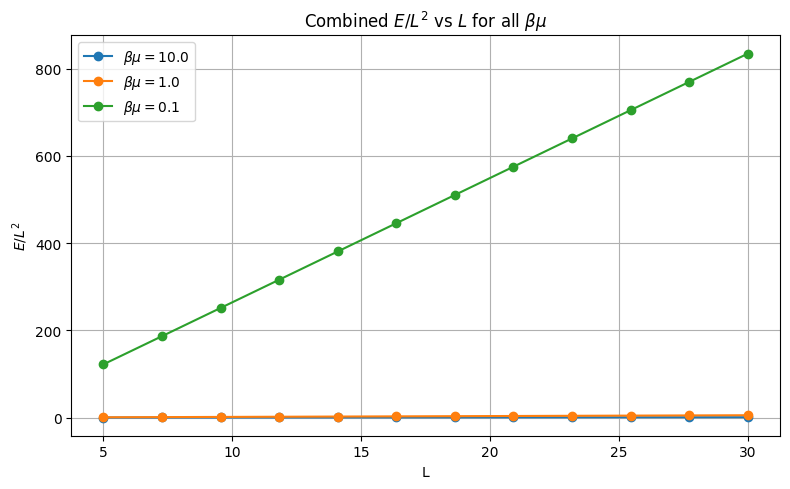


========= SUMMARY TABLE =========
 beta*mu    rho_E (slope)     sigma_E (intercept/6)    max|deltaE|
  10.000   2.99580920e-02   -1.78773410e-02   1.474194e+00
   1.000   1.89430731e-01   -6.51929057e-02   5.177327e+00
   0.100   2.84944765e+01   -3.44749113e+00   8.598192e+01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# --------------------------
# Parameters (adjust as needed)
# --------------------------
hbar = 1.0   # set to 1 for convenience (rescale later if desired)
m = 1.0      # set to 1
C = (hbar**2 * np.pi**2) / (2.0 * m)   # prefactor in eps = C * n^2 / L^2

mu = 1.0                              # chemical potential (choose units consistent with C)
beta_values = [10.0, 1.0, 0.1]        # gives beta*mu = 10, 1, 0.1 when mu=1
L_values = np.linspace(5.0, 30.0, 12) # you can change spacing or range
alpha_cut = 12.0                      # number of kT above mu to include (thermal cutoff parameter)
convergence_tol = 1e-6                # optional convergence tolerance on E when raising cutoff

# --------------------------
# Numerically-stable FD
# --------------------------
def fermi_dirac_stable(x):
    # x = beta*(eps - mu). Vectorized.
    # For large positive x => occupation ~ 0
    # For large negative x => occupation ~ 1
    # Only compute exp(x) when x is moderate.
    out = np.empty_like(x, dtype=float)
    out[:] = 0.0
    mask_high = x > 50.0
    mask_low = x < -50.0
    mask_mid = ~(mask_high | mask_low)
    out[mask_high] = 0.0
    out[mask_low] = 1.0
    out[mask_mid] = 1.0 / (np.exp(x[mask_mid]) + 1.0)
    return out

# --------------------------
# Compute energy using multiplicity grouping
# --------------------------
def compute_energy_with_multiplicity(L, mu, beta, alpha=alpha_cut):
    """
    Compute total energy for a cube of side L by:
      - choosing eps_cut = mu + alpha/beta
      - computing nmax from eps_cut
      - enumerating integer triples 1..nmax, grouping by n^2 multiplicity
      - summing eps * f(eps) * multiplicity
    Returns total_energy, nmax
    """
    eps_cut = mu + alpha / beta

    # minimal n^2 is 1^2+1^2+1^2 = 3
    # invert eps = C * n^2 / L^2 => n^2_max = eps_cut * L^2 / C
    n2_max = eps_cut * (L**2) / C
    nmax = max(1, int(np.floor(np.sqrt(n2_max))) )  # at least 1, but we will add some safety margin
    # add small safety margin to ensure we include near-cutoff states
    nmax += 2

    # Build 3D n^2 array vectorized if not too large.
    # Check memory: (nmax)^3 should be manageable for nmax ~ up to few hundreds.
    n = np.arange(1, nmax + 1, dtype=int)
    n2 = n**2

    # build 3d nsq array using broadcasting, then flatten and bincount multiplicity
    # nsq = nx2[:,None,None] + ny2[None,:,None] + nz2[None,None,:]
    nx2 = n2[:, None, None]    # shape (nmax,1,1)
    ny2 = n2[None, :, None]    # shape (1,nmax,1)
    nz2 = n2[None, None, :]    # shape (1,1,nmax)
    nsq_3d = nx2 + ny2 + nz2   # shape (nmax,nmax,nmax)
    nsq_flat = nsq_3d.ravel()
    max_nsq = int(nsq_flat.max())
    counts = np.bincount(nsq_flat)  # counts[k] = multiplicity of n^2 == k; index 0..max_nsq

    # Consider only n^2 >= 3 because nx,ny,nz >=1 produces minimum 3; counts[0..2] will be zero
    # Build array of n2_values and multiplicities where multiplicity > 0
    n2_values = np.nonzero(counts)[0]   # indices where count>0
    multiplicities = counts[n2_values]

    # compute eps for each distinct n^2
    eps_values = C * n2_values / (L**2)   # vector
    x = beta * (eps_values - mu)
    occ = fermi_dirac_stable(x)           # occupation for each n^2

    # energy sum: sum_over_n2 [ eps(n2) * occ(n2) * multiplicity(n2) ]
    E_total = np.sum(eps_values * occ * multiplicities)

    return float(E_total), nmax

def compute_energy_converged(L, mu, beta, alphas=[8,12,16]):
    """
    Try several alpha values and check convergence of E.
    Returns energy computed with the largest alpha and the sequence of energies.
    """
    E_list = []
    nmax_list = []
    for a in alphas:
        E, nmax = compute_energy_with_multiplicity(L, mu, beta, alpha=a)
        E_list.append(E)
        nmax_list.append(nmax)
    return E_list[-1], nmax_list[-1], E_list, nmax_list

# --------------------------
# Main loop: compute energies for each beta and L
# --------------------------
results = {}
for beta in beta_values:
    Evals = []
    nmax_vals = []
    for L in L_values:
        E, nmax, E_history, nmax_history = compute_energy_converged(L, mu, beta, alphas=[8,12,16])
        Evals.append(E)
        nmax_vals.append(nmax)
    results[beta] = {"L": np.array(L_values), "E": np.array(Evals), "nmax": np.array(nmax_vals)}

# --------------------------
# Fit E/L^2 vs L, plot combined, print rho,sigma,delta
# --------------------------
plt.figure(figsize=(8,5))
print("\n================= RESULTS =================")
for beta in beta_values:
    L = results[beta]["L"]
    E = results[beta]["E"]
    y = E / (L**2)

    # linear fit: y = intercept + slope * L    (intercept = 6*sigma_E, slope = rho_E)
    coefs = polyfit(L, y, 1)   # returns [c0 (intercept), c1 (slope)]
    intercept = coefs[0]
    rho_E = coefs[1]
    sigma_E = intercept / 6.0

    # reconstruct fitted energy and deltaE
    E_fit = rho_E * L**3 + 6.0 * sigma_E * L**2
    deltaE = E - E_fit
    deltaE_max = np.max(np.abs(deltaE))

    # store
    results[beta].update({
        "rho_E": rho_E,
        "sigma_E": sigma_E,
        "E_fit": E_fit,
        "deltaE": deltaE,
        "deltaE_max": deltaE_max
    })

    # print detailed output
    print(f"\n--- beta*mu = {beta*mu:.3f}  (beta={beta:.6g})  ---")
    print(f"rho_E   = {rho_E:.8e}")
    print(f"sigma_E = {sigma_E:.8e}")
    print("L       E               deltaE")
    for Li, Ei, dEi in zip(L, E, deltaE):
        print(f"{Li:6.3f}  {Ei:12.6e}  {dEi: .6e}")
    print(f"max |deltaE| = {deltaE_max:.6e}")
    # add to combined plot
    plt.plot(L, y, marker='o', linestyle='-', label=rf"$\beta\mu={beta*mu}$")

plt.xlabel("L")
plt.ylabel(r"$E/L^2$")
plt.title(r"Combined $E/L^2$ vs $L$ for all $\beta\mu$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# summary table
print("\n========= SUMMARY TABLE =========")
print(" beta*mu    rho_E (slope)     sigma_E (intercept/6)    max|deltaE|")
for beta in beta_values:
    print(f"{beta*mu:8.3f}   {results[beta]['rho_E']:14.8e}   {results[beta]['sigma_E']:14.8e}   {results[beta]['deltaE_max']:12.6e}")
print("=================================")


In [ ]:
# --------------------------
# Convergence helper (optional)
# --------------------------
def compute_energy_converged(L, mu, beta, alphas=[8,12,16]):
    """
    Try several alpha values and check convergence of E.
    Returns energy computed with the largest alpha and the sequence of energies.
    """
    E_list = []
    nmax_list = []
    for a in alphas:
        E, nmax = compute_energy_with_multiplicity(L, mu, beta, alpha=a)
        E_list.append(E)
        nmax_list.append(nmax)
    # simple convergence check: compare last two energies
    if len(E_list) >= 2:
        if abs(E_list[-1] - E_list[-2]) > convergence_tol * max(1.0, abs(E_list[-1])):
            print(f"Warning: energy not converged for L={L:.3f}, beta={beta:.3g}. "
                  f"Delta between alphas {alphas[-2]} and {alphas[-1]} is "
                  f"{E_list[-1]-E_list[-2]:.3e}. Consider increasing alpha or nmax.")
    return E_list[-1], nmax_list[-1], E_list, nmax_list